`Deep Learning By PhD Scholar`
## Problems in the FER 2013 dataset
- **Imbalance**: 7214 pictures of happy but only 436 of disgust. Neural netowrk will be biased towards 'Happy'
Soln: **Data Augmentation** (Create more images by rotation, scale etc)
- **Intra-class Variation**: All images do not belong to same class (eg. FER contains faces, paintings, cartoons etc)
Soln: Avoid Overfitting
- **Occlusion**: Parts covered with hand
- **Contrast Variation**: Images too black and white
- **Eyeglasses**
- **Outliers**

## Methodology
FER 2013 dataset (48x48) --bilinear interpolation--> 224x224 --> **Transfer Learning** (MobileNetv2, GoogleNet, ResNet, AlexNet etc [trained for 224x224 images to classify into 1000 classes])

Scope for improvement:
- Batch Learning
- ResNetv3
- Freezing initial weights
- increasing epochs

In [1]:
import tensorflow as tf
import cv2

import os
import matplotlib.pyplot as plt 
import numpy as np

In [2]:
img_array = cv2.imread('images/train/0/0.jpg')
img_array.shape  # (48, 48, 3), rgb image

(48, 48, 3)

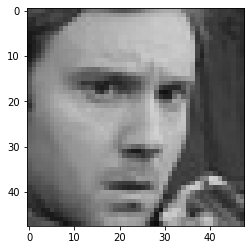

In [3]:
plt.imshow(img_array)  # Image is blurry

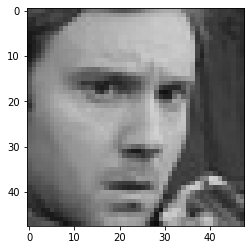

In [4]:
data_dir = "images/train/"
classes = ["0", "1", "2", "3", "4", "5", "6"]

# Loop through all the images in the train folder
for category in classes:
    path = os.path.join(data_dir, category)
    
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img))
        # back2rgb = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)
        plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
        plt.show()
        break
    
    break

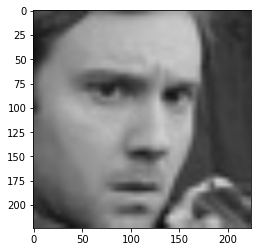

In [5]:
# Change the size of the images (Upsscale them to 224x224)
img_size = 224
new_array = cv2.resize(img_array, (img_size, img_size))
plt.imshow(cv2.cvtColor(new_array, cv2.COLOR_BGR2RGB))
# new_array has shape (224, 224, 3)

In [6]:
from tqdm.notebook import tqdm 

# Read all the images and convert them to array

training_data = []

def create_training_data():
    for class_num, category in enumerate(classes):
        path = os.path.join(data_dir, category)
        
        for img in tqdm(os.listdir(path)):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, (img_size, img_size))
                training_data.append([new_array, class_num])            # Append as (img_array, label)
            except Exception as e:
                print(f"Error in processing {os.path.join(path, img)}")

create_training_data()

  0%|          | 0/3993 [00:00<?, ?it/s]

  0%|          | 0/436 [00:00<?, ?it/s]

  0%|          | 0/4103 [00:00<?, ?it/s]

  0%|          | 0/7164 [00:00<?, ?it/s]

  0%|          | 0/4982 [00:00<?, ?it/s]

  0%|          | 0/4938 [00:00<?, ?it/s]

  0%|          | 0/3205 [00:00<?, ?it/s]

In [7]:
import random

# Shuffling the data
random.shuffle(training_data)

In [8]:
X = []  # Data/Features (image arrays)
y = []  # labels

print(len(training_data)//5)
for features, label in tqdm(training_data[:len(training_data)//10]):     # 6.4 GB
    X.append(features)
    y.append(label)

del training_data
# print(len(X))
# print(X[0].shape)
# print(len(y))
    
X = np.array(X).reshape(-1, img_size, img_size, 3)

5764


  0%|          | 0/2882 [00:00<?, ?it/s]

In [9]:
# Normalizing

# X = X/255.0
# Log: MemoryError: Unable to allocate 32.3 GiB for an array with shape (28821, 224, 224, 3) and data type float64
#                   TODO: Train in batches

X = X/255.0   
Y = np.array(y)


In [10]:
# Creating the model

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [11]:
X.shape

(2882, 224, 224, 3)

In [12]:
model = tf.keras.applications.MobileNetV2()  # TODO: Try out v3
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [13]:
base_input = model.layers[0].input
base_output = model.layers[-2].output     # Since last layer is used for output of 1000 class classification, we ignore that layer and take the second last layer

In [14]:
final_output = layers.Dense(128)(base_output)
final_output = layers.Activation('relu')(final_output)

final_output = layers.Dense(64)(base_output)
final_output = layers.Activation('relu')(final_output)

final_output = layers.Dense(7, activation='softmax')(final_output)

In [15]:
new_model = keras.Model(inputs = base_input, outputs=final_output)
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

                                                                                                  
 expanded_conv_depthwise_BN (Ba  (None, 112, 112, 32  128        ['expanded_conv_depthwise[0][0]']
 tchNormalization)              )                                                                 
                                                                                                  
 expanded_conv_depthwise_relu (  (None, 112, 112, 32  0          ['expanded_conv_depthwise_BN[0][0
 ReLU)                          )                                ]']                              
                                                                                                  
 expanded_conv_project (Conv2D)  (None, 112, 112, 16  512        ['expanded_conv_depthwise_relu[0]
                                )                                [0]']                            
                                                                                                  
 expanded_

In [16]:
new_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

## Loss Function: Sparse Categorical Crossentropy
Both `Sparse Categroical Crossentropy` and `Categorical Crossentropy` have the same loss function. The only difference is in the form of label
- When the labels are `one-hot encoded`, we use `Categorical Crossentropy` (eg. [0, 0, 1] for 1, [0, 1, 0] for 2 and [1, 0, 0] for 3)
- When the labels are `integers`, we use `Spare Categorical Crossentropy`

In [17]:
new_model.fit(X, Y, epochs=25)

Epoch 1/25


ResourceExhaustedError: Graph execution error:

Detected at node 'model/block_1_expand_BN/FusedBatchNormV3' defined at (most recent call last):
    File "c:\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Python\Python310\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Python\Python310\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Python\Python310\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Python\Python310\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Python\Python310\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Python\Python310\lib\asyncio\base_events.py", line 1899, in _run_once
      handle._run()
    File "c:\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 542, in dispatch_queue
      await self.process_one()
    File "c:\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 531, in process_one
      await dispatch(*args)
    File "c:\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Python\Python310\lib\site-packages\ipykernel\ipkernel.py", line 359, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 775, in execute_request
      reply_content = await reply_content
    File "c:\Python\Python310\lib\site-packages\ipykernel\ipkernel.py", line 453, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "c:\Python\Python310\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\zenga\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 2768, in run_cell
      result = self._run_cell(
    File "C:\Users\zenga\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 2814, in _run_cell
      return runner(coro)
    File "C:\Users\zenga\AppData\Roaming\Python\Python310\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\zenga\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3012, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\zenga\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3191, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\zenga\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3251, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\zenga\AppData\Local\Temp\ipykernel_22924\1590459653.py", line 1, in <module>
      new_model.fit(X, Y, epochs=25)
    File "c:\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Python\Python310\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Python\Python310\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Python\Python310\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Python\Python310\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Python\Python310\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Python\Python310\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Python\Python310\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Python\Python310\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Python\Python310\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Python\Python310\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Python\Python310\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 850, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "c:\Python\Python310\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 660, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "c:\Python\Python310\lib\site-packages\keras\utils\control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "c:\Python\Python310\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 634, in _fused_batch_norm_training
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'model/block_1_expand_BN/FusedBatchNormV3'
OOM when allocating tensor with shape[32,96,112,112] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/block_1_expand_BN/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_11142]

In [ ]:
new_model.save('emo_detect_v1.h5')